# Water Scarcity and Global Conflict Analysis
This project aims to explore the complex relationship between armed conflict and water scarcity by integrating and analyzing datasets from various sources. We will leverage geospatial and environmental data to assess how water scarcity influences the occurrence and intensity of confict

## Project Summary

### Hypothesis: 
Water is one of the most critical resources on the planet for human survival. When the demand for critical resources, such as water, exceeds the supply, the number of conflicts increases.

### Questions:
- How does water scarcity correlate with the frequency and intensity of armed conflicts?
- What are the geographical patterns of conflict relative to water scarcity?
- Can changes in water availability predict increases in conflict events?
- Are certain types of conflicts more likely to occur in water-scarce regions?
- Are there other factors that affect the frequency of armed conflicts in water scarce areas?

### Data Sources
- Food and Agriculture Organization (FAO) https://data.apps.fao.org/aquastat/?lang=en
- University of Alabama https://internationalconflict.ua.edu/data-download/
- Correlates of War (COW) https://correlatesofwar.org/data-sets/cow-country-codes.csv
- World Bank Group's Data Bank https://databank.worldbank.org/reportsup.html

## Question 1 - How does water scarcity correlate with the frequency and intensity of armed conflicts?

In [4]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import stats
from scipy.stats import pearsonr
from functools import partial, reduce

In [5]:
# Load the datasets
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System.csv') # FAO Aquastat Data
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv') # University of Alabama International Conflict Data
cow_country_codes = pd.read_csv('Resources/COW-country-codes.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')
WDI_df = pd.read_csv('Resources/WDI_World.csv')

In [6]:
# Associate name with country code using COW country codes
code_to_country = pd.Series(cow_country_codes.StateNme.values, index=cow_country_codes.CCode).to_dict()

In [7]:
# cont. above
mie_csv['ccode1'] = mie_csv['ccode1'].map(code_to_country)
mie_csv['ccode2'] = mie_csv['ccode2'].map(code_to_country)
mie_csv.head()

,micnum,eventnum,ccode1,ccode2,stmon,stday,styear,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,2,1,United States of America,United Kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,3,1,Austria-Hungary,Yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,4,2,Albania,United Kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,4,3,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,4,4,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0


In [8]:
# Rename columns for clarity
mie_csv = mie_csv.rename(columns={'ccode1': 'Country'})
mie_csv = mie_csv.rename(columns={'ccode2': 'Target Country'})
aqua_csv = aqua_csv.rename(columns={'Area': 'Country'})
COW_Country_Codes = cow_country_codes.rename(columns={'StateNme':'Country'})
mie_csv = mie_csv.rename(columns={'styear': 'Year'})

In [9]:
# Create and display dataframe
mie_df = pd.DataFrame(mie_csv)
mie_df

,micnum,eventnum,Country,Target Country,stmon,stday,Year,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,2,1,United States of America,United Kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,3,1,Austria-Hungary,Yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,4,2,Albania,United Kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,4,3,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,4,4,United Kingdom,Albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28006,9946,1,Peru,Ecuador,10,4,1859,10,4,1859,1,7,3,0,0,0,0,mie-1.0
28007,9946,2,Peru,Ecuador,11,8,1859,1,25,1860,1,14,4,0,0,0,0,mie-1.0
28008,9947,1,Cambodia,Vietnam,5,-9,1975,5,-9,1975,1,17,4,0,0,0,0,mie-1.0
28009,9947,2,Vietnam,Cambodia,6,10,1975,12,7,1975,0,14,4,0,0,0,0,mie-1.0


In [10]:
# Filter for years between 1980 and 2015
filtered_year_df = mie_df[(mie_df['Year'] >= 1980) & (mie_df['Year'] <= 2015)]

# Flter for specific countries, e.g., 'USA' and 'Canada'
countries = mie_df['Country']
filtered_df = filtered_year_df[filtered_year_df['Country'].isin(countries)]

# Group by 'Year' and count unique 'micnum' for each year
mie_per_year_df = filtered_df.groupby(['Year', 'Country'])['micnum'].nunique().reset_index()

# Rename columns for clarity
mie_per_year_df.columns = ['Year', 'Country', 'Number_of_Conflicts']

# Display the result
mie_per_year_df.head(10)

,Year,Country,Number_of_Conflicts
0,1980,Afghanistan,1
1,1980,Angola,1
2,1980,Argentina,1
3,1980,Canada,1
4,1980,Chile,1
5,1980,Colombia,1
6,1980,Cuba,2
7,1980,Democratic Republic of the Congo,1
8,1980,Egypt,1
9,1980,Ethiopia,1


In [11]:
# Create a dataframe to calculate total conflicts per year
total_conflicts_per_year_df = mie_per_year_df.groupby('Year')['Number_of_Conflicts'].sum().reset_index()

# Rename columns for clarity
total_conflicts_per_year_df.columns = ['Year', 'Total_Conflicts']

# Display the result
print("Total Conflicts per Year:\n", total_conflicts_per_year_df)

Total Conflicts per Year:
     Year  Total_Conflicts
0   1980               57
1   1981               51
2   1982               51
3   1983               69
4   1984               67
5   1985               54
6   1986               53
7   1987               66
8   1988               30
9   1989               28
10  1990               17
11  1991               32
12  1992               44
13  1993               79
14  1994               66
15  1995               68
16  1996               64
17  1997               64
18  1998               78
19  1999               87
20  2000               60
21  2001               74
22  2002               70
23  2003               73
24  2004               49
25  2005               58
26  2006               41
27  2007               35
28  2008               39
29  2009               32
30  2010               37
31  2011               97
32  2012               60
33  2013               70
34  2014               75


In [12]:
# Create a dataframe to calculate the numbers of conflict per year by country
no_of_countries_by_year_df = filtered_df.groupby('Year')['Country'].nunique().reset_index()

# Specify the columns
no_of_countries_by_year_df.columns = ['Year', 'Number_of_Countries_in_Conflict']

# Display the dataframe
no_of_countries_by_year_df

,Year,Number_of_Countries_in_Conflict
0,1980,41
1,1981,35
2,1982,36
3,1983,43
4,1984,44
5,1985,35
6,1986,33
7,1987,40
8,1988,20
9,1989,23


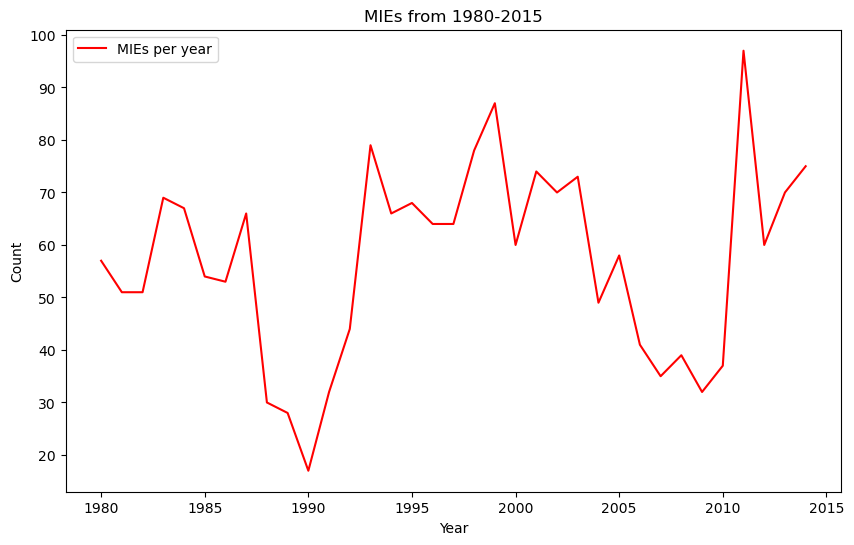

In [13]:
# Plot conflicts between 1980-2015  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
plt.xlabel('Year')
plt.ylabel('Count') 
plt.legend()
plt.show()

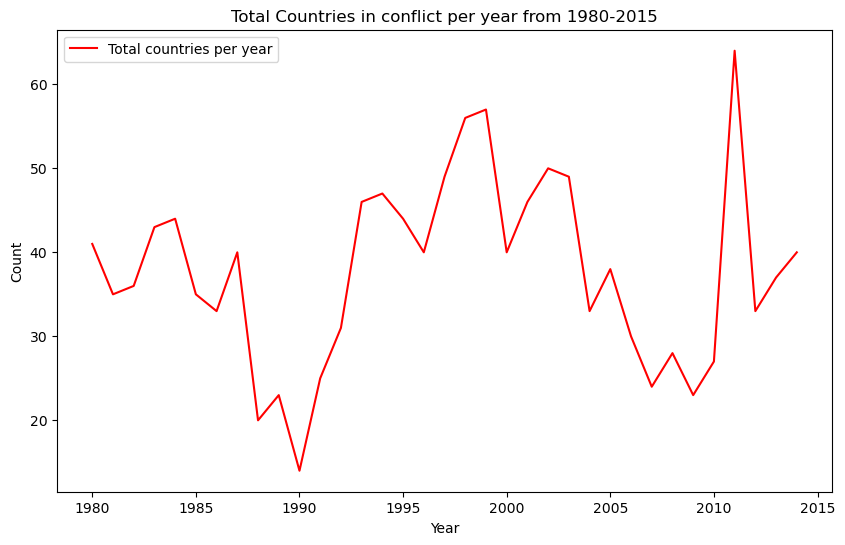

In [14]:
# Plot total countries in conflit per year between 1980-2015  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
plt.xlabel('Year')
plt.ylabel('Count') 
plt.legend()
plt.show()

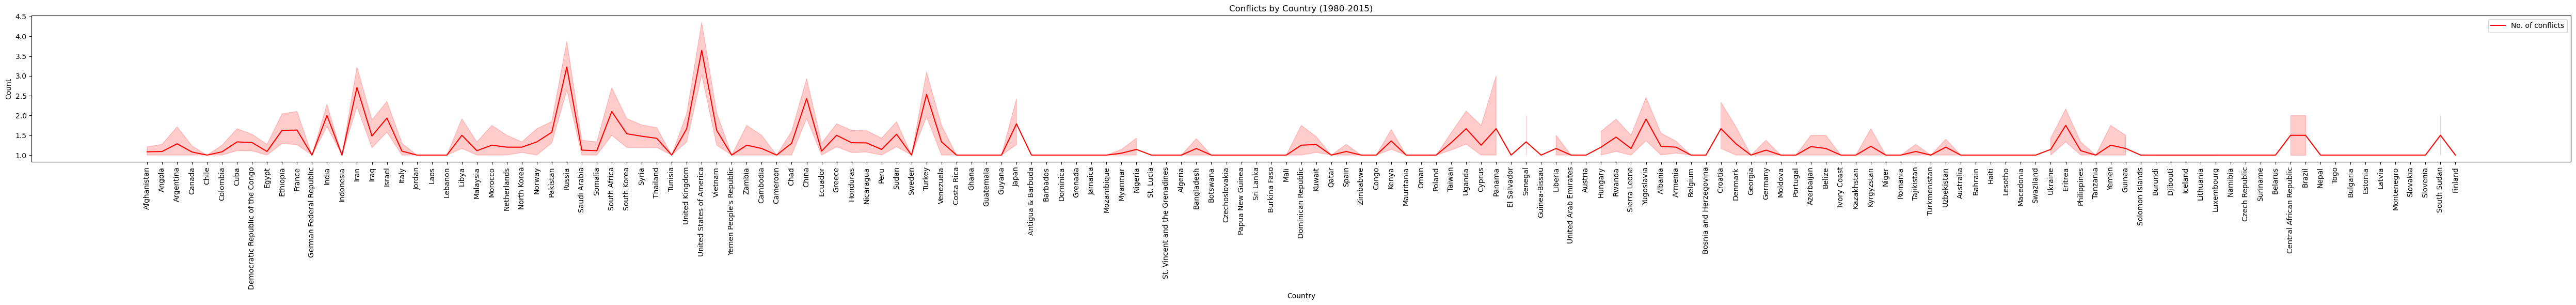

In [15]:
# Plot conflicts by country between 1980-2015  - NOT USED IN PRESENTATION
plt.figure(figsize=(50, 6))
sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
plt.title('Conflicts by Country (1980-2015)')
plt.xlabel('Country')
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Filter water stress data to include only those rows including the keyword "SDG 6.4.2. Water Stress" in the variable column
water_df = pd.DataFrame(aqua_csv)
keyword = 'SDG 6.4.2. Water Stress'
filtered_water = aqua_csv['Variable'].str.contains(keyword, na=False)
filtered_water_df = water_df[filtered_water]

# Display the dataframe
filtered_water_df.head()

,VariableGroup,Subgroup,Variable,Country,Year,Value,Unit,Symbol,IsAggregate
28609,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1981,49.69101,%,E,False
28610,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1982,53.15823,%,E,False
28611,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1983,56.62545,%,E,False
28612,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1984,60.09267,%,E,False
28613,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1985,63.55989,%,E,False


In [17]:
# Drop unneccesary columns (Source of code: ChatGPT)
water_columns_to_drop = ['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate']
existing_water_columns_to_drop = [col for col in water_columns_to_drop if col in filtered_water_df.columns]

if existing_water_columns_to_drop:
   filtered_water_df = filtered_water_df.drop(columns=existing_water_columns_to_drop)
else:
    print("No columns to drop.")

In [18]:
# Display the dataframe to ensure unneccesary columns were dropped
filtered_water_df.head()

,Country,Year,Value
28609,Afghanistan,1981,49.69101
28610,Afghanistan,1982,53.15823
28611,Afghanistan,1983,56.62545
28612,Afghanistan,1984,60.09267
28613,Afghanistan,1985,63.55989


In [19]:
# Filter data to include only the information from 1980 to 2015
filtered_water_by_year_df = filtered_water_df[(filtered_water_df['Year'] >= 1980) & (filtered_water_df['Year'] <= 2015)]

In [20]:
#Groupby year and value
overall_percentage_per_year_df = pd.DataFrame(filtered_water_by_year_df.groupby('Year')['Value'].mean().reset_index())

# Display the dataframe
overall_percentage_per_year_df

,Year,Value
0,1981,57.192850
1,1982,59.129871
2,1983,62.086189
3,1984,64.124653
4,1985,61.485680
5,1986,62.858329
6,1987,46.081684
7,1988,47.134030
8,1989,48.748405
9,1990,47.181621


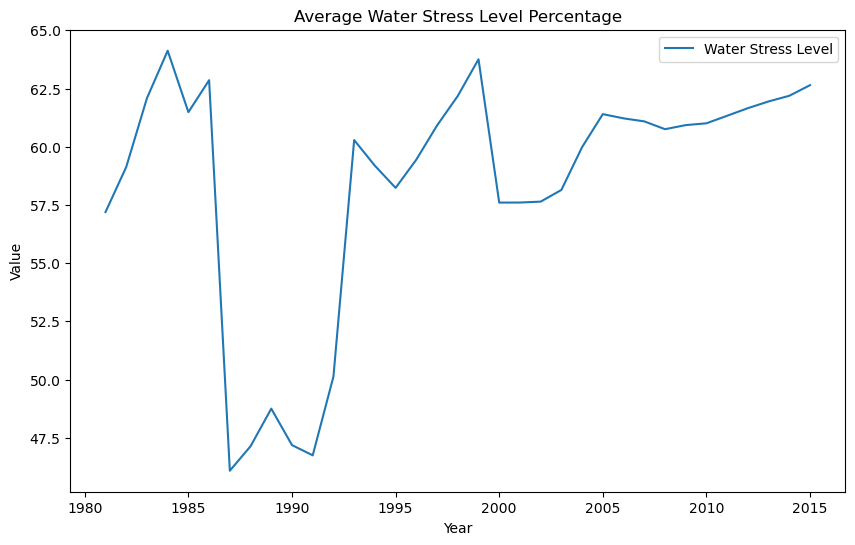

In [21]:
# Plot Total Water Stress Level by year by average  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.title('Average Water Stress Level Percentage')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
# Calculate the total global water stress per year (numbers in data are a percentage, but I wanted to see how this looked as well)
total_value_per_year_df = pd.DataFrame(filtered_water_by_year_df.groupby('Year')['Value'].sum().reset_index())

# Display the dataframe
total_value_per_year_df

,Year,Value
0,1981,3088.413899
1,1982,3252.142902
2,1983,3414.740393
3,1984,3590.980563
4,1985,3750.626476
5,1986,3897.216413
6,1987,4101.269832
7,1988,4242.062680
8,1989,4387.356432
9,1990,4812.525321


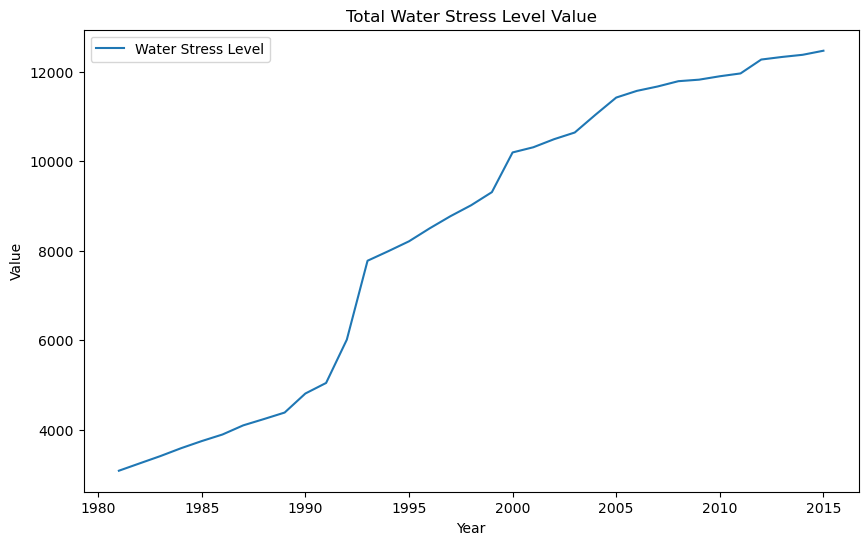

In [24]:
# Plot Total Water Stress Level by year by sum  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_value_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.title('Total Water Stress Level Value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [25]:
#Further filter water data by country and count total water stress per country between years 1980-2015
water_country_counts = filtered_water_by_year_df['Country'].value_counts().sort_index()
water_stress_per_country_df = pd.DataFrame({'Country': water_country_counts.index, 'Count': water_country_counts.values})

#Dislpay the dataframe
water_stress_per_country_df

,Country,Count
0,Afghanistan,35
1,Albania,26
2,Algeria,35
3,Angola,29
4,Antigua and Barbuda,26
...,...,...
194,Western Asia,16
195,World,16
196,Yemen,26
197,Zambia,24


In [26]:
# Calculate the total percentage per country per year, create dataframe
overall_percentage_per_country_df = pd.DataFrame(filtered_water_by_year_df.groupby('Country')['Value'].mean().reset_index())

# Display dataframe
overall_percentage_per_country_df

,Country,Value
0,Afghanistan,58.071436
1,Albania,7.921158
2,Algeria,78.626706
3,Angola,1.673621
4,Antigua and Barbuda,7.433432
...,...,...
194,Western Asia,59.696875
195,World,17.894375
196,Yemen,160.847985
197,Zambia,2.905581


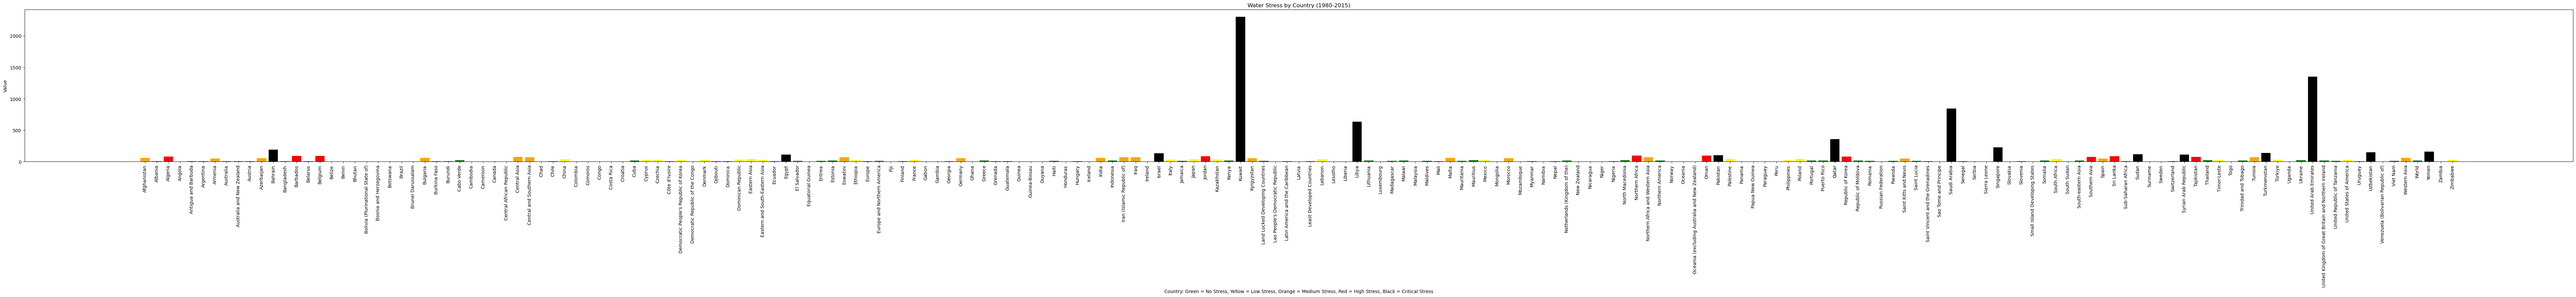

In [27]:
# Plot the country specific data, color coding water stress levels

# Define conditions and corresponding colors   - NOT USED IN PRESENTATION
conditions = [
    (overall_percentage_per_country_df['Value'] <= 25),
    (overall_percentage_per_country_df['Value'] > 25) & (overall_percentage_per_country_df['Value'] <= 50),
    (overall_percentage_per_country_df['Value'] > 50) & (overall_percentage_per_country_df['Value'] <= 75),
    (overall_percentage_per_country_df['Value'] > 75) & (overall_percentage_per_country_df['Value'] <= 100)
]
colors = ['green', 'yellow', 'orange', 'red']

# Use np.select to assign colors based on conditions
overall_percentage_per_country_df['Color'] = np.select(conditions, colors, default='black')

# Plotting
fig, ax = plt.subplots(figsize=(100, 6))

# Plot bars manually
bars = ax.bar(overall_percentage_per_country_df['Country'], overall_percentage_per_country_df['Value'], color=overall_percentage_per_country_df['Color'])

# Add titles and labels
ax.set_title('Water Stress by Country (1980-2015)')
ax.set_xlabel('Country: Green = No Stress, Yellow = Low Stress, Orange = Medium Stress, Red = High Stress, Black = Critical Stress')
ax.set_ylabel('Value')
ax.tick_params(axis='x', labelrotation=90)

plt.show()

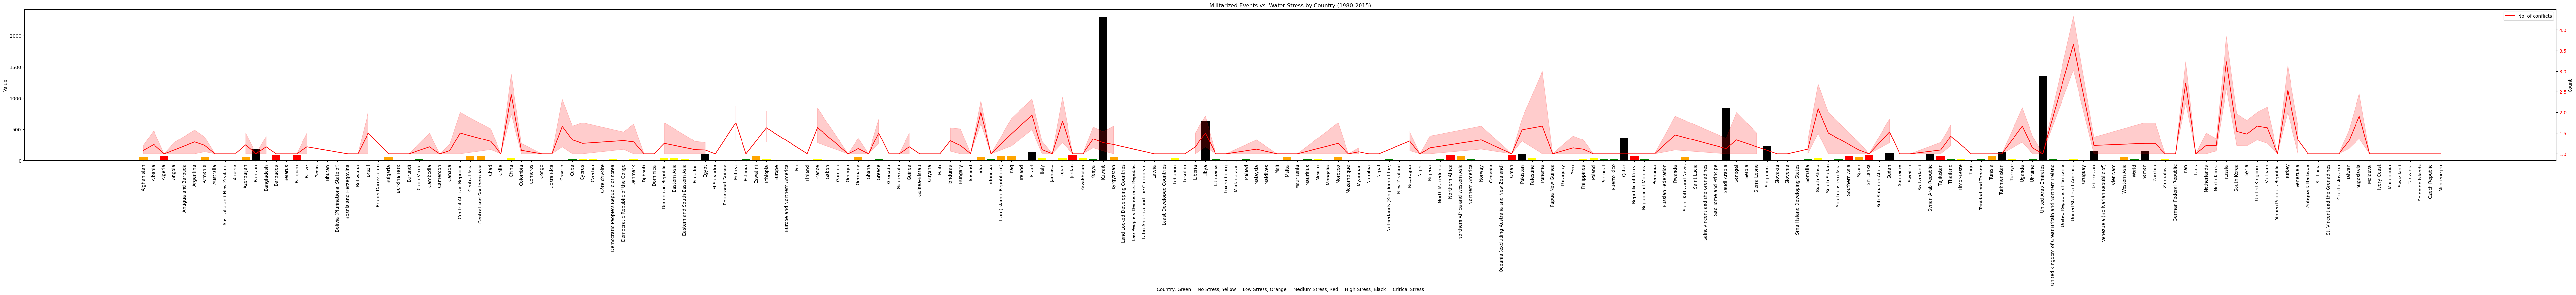

In [28]:
# Plot the color coded water stress data with the conflict data

# Define conditions and corresponding colors  - NOT USED IN PRESENTATION
conditions = [
    (overall_percentage_per_country_df['Value'] <= 25),
    (overall_percentage_per_country_df['Value'] > 25) & (overall_percentage_per_country_df['Value'] <= 50),
    (overall_percentage_per_country_df['Value'] > 50) & (overall_percentage_per_country_df['Value'] <= 75),
    (overall_percentage_per_country_df['Value'] > 75) & (overall_percentage_per_country_df['Value'] <= 100)
]
colors = ['green', 'yellow', 'orange', 'red']

# Use np.select to assign colors based on conditions
overall_percentage_per_country_df['Color'] = np.select(conditions, colors, default='black')

# Plotting
fig, ax = plt.subplots(figsize=(100, 6))

# Plot bars manually
bars = ax.bar(overall_percentage_per_country_df['Country'], overall_percentage_per_country_df['Value'], color=overall_percentage_per_country_df['Color'])

# Add titles and labels
ax.set_title('Militarized Events vs. Water Stress by Country (1980-2015)')
ax.set_xlabel('Country: Green = No Stress, Yellow = Low Stress, Orange = Medium Stress, Red = High Stress, Black = Critical Stress')
ax.set_ylabel('Value')
ax.tick_params(axis='x', labelrotation=90)

ax2 = ax.twinx()

sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
ax2.set_xlabel('Country')
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='x', labelrotation=90)

plt.savefig('militarized_events_vs_water_stress_by_country.png_color_coded.png', bbox_inches='tight') 
plt.show()

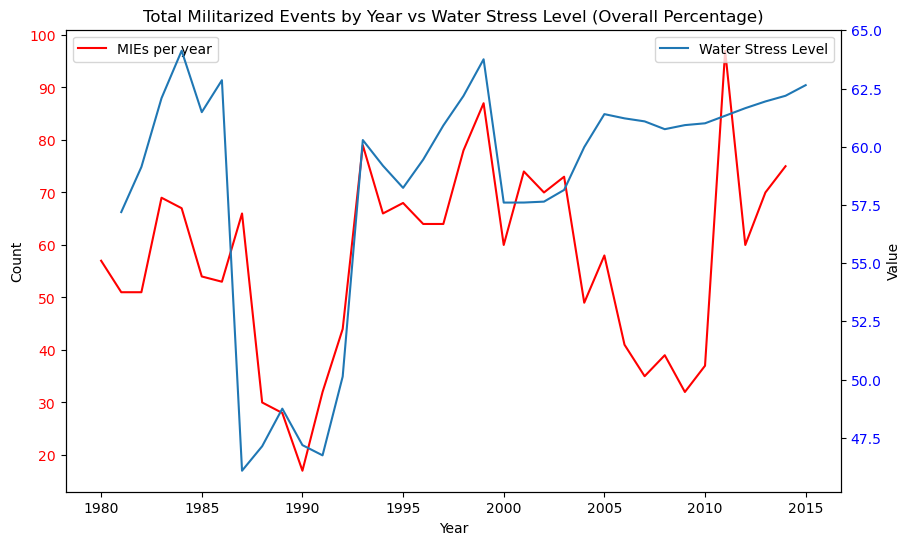

In [29]:
#Plot Total Militarized Events by Year vs Water Stress Level (Overall Percentage) - USED ON SLIDE 2
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events by Year vs Water Stress Level (Overall Percentage)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_year.png', bbox_inches='tight') 
plt.show()

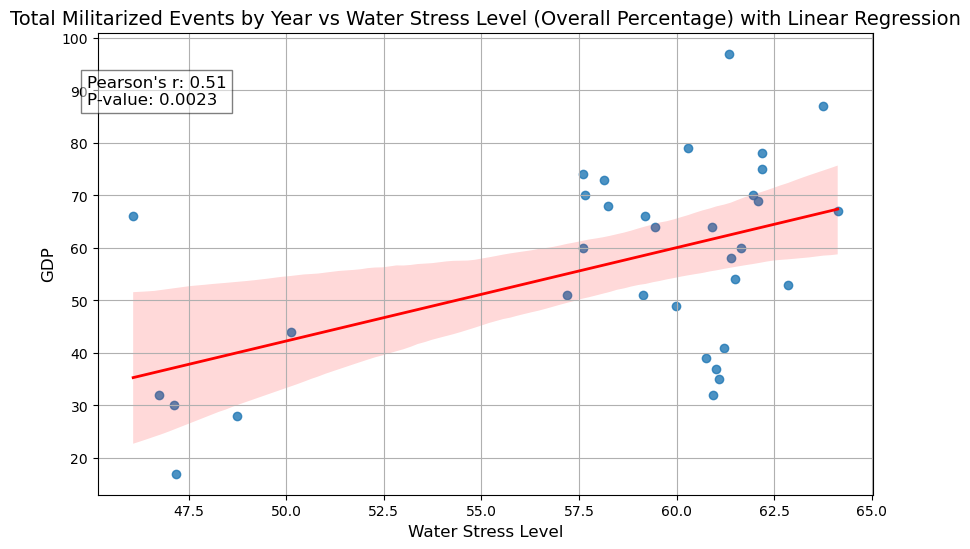

In [90]:
# Plot and calculate p and r values and linear regression

# Calculate correlation between Total Militarized Events by Year vs Water Stress Level (Overall Percentage)
# Align the datasets on the same years
mie_water_stress_merged_df = overall_percentage_per_year_df.merge(total_conflicts_per_year_df, on='Year')
water_stress_values = mie_water_stress_merged_df['Value']
total_conflicts_values = mie_water_stress_merged_df['Total_Conflicts']

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, total_conflicts_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=water_stress_values, y=total_conflicts_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Total Militarized Events by Year vs Water Stress Level (Overall Percentage) with Linear Regression', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('GDP', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(total_conflicts_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('water_stress_total_conflicts_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

# Total Militarized Events by Year vs Water Stress Level (Overall Percentage)
# Moderate positive linear correlation (r = 0.51)
# Strong evidence against the null hypothesis (p = 0.0023)

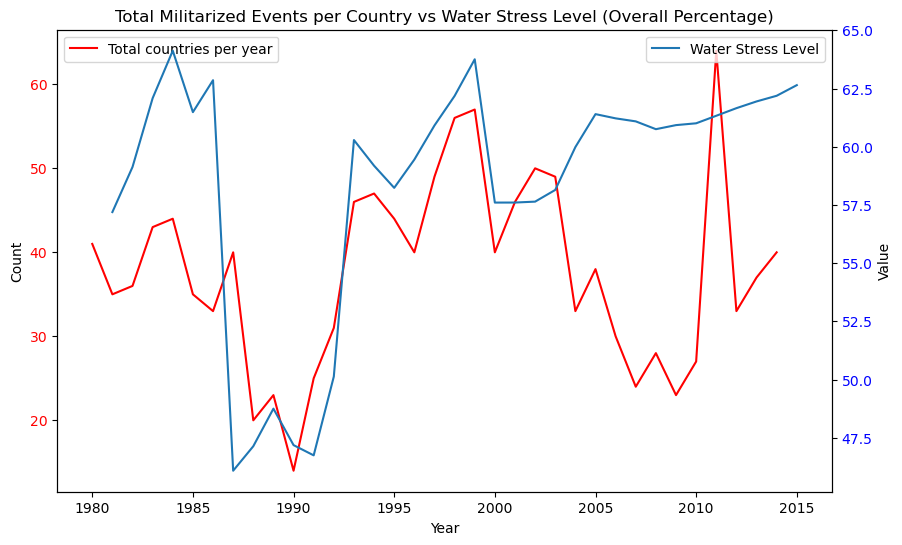

In [54]:
#Plot Total Militarized Events per Country vs Water Stress Level (Overall Percentage)  - USED ON SLIDE 2
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events per Country vs Water Stress Level (Overall Percentage)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_country.png', bbox_inches='tight') 
plt.show()


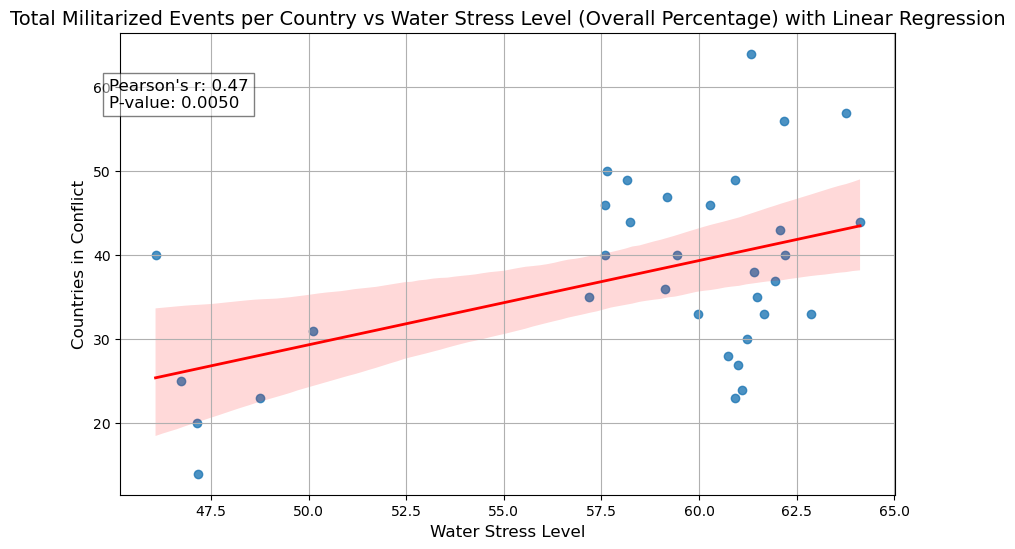

In [91]:
# Plot and calculate p and r values and linear regression

# Calculate Correlation between Total Militarized Events per Country by Year vs Water Stress Level (Overall Percentage)
# Align the datasets on the same years
mie_water_stress_country_merged_df = overall_percentage_per_year_df.merge(no_of_countries_by_year_df, on='Year')
water_stress_values = mie_water_stress_country_merged_df['Value']
country_values = mie_water_stress_country_merged_df['Number_of_Countries_in_Conflict']

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, country_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=water_stress_values, y=country_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Total Militarized Events per Country vs Water Stress Level (Overall Percentage) with Linear Regression', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('Countries in Conflict', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(country_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('water_stress_total_conflicts_by_country_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()
# Total Militarized Events per Country by Year vs Water Stress Level (Overall Percentage)
# Moderate positive linear correlation (r = 0.47)
# Strong evidence against the null hypothesis (p = 0.005)

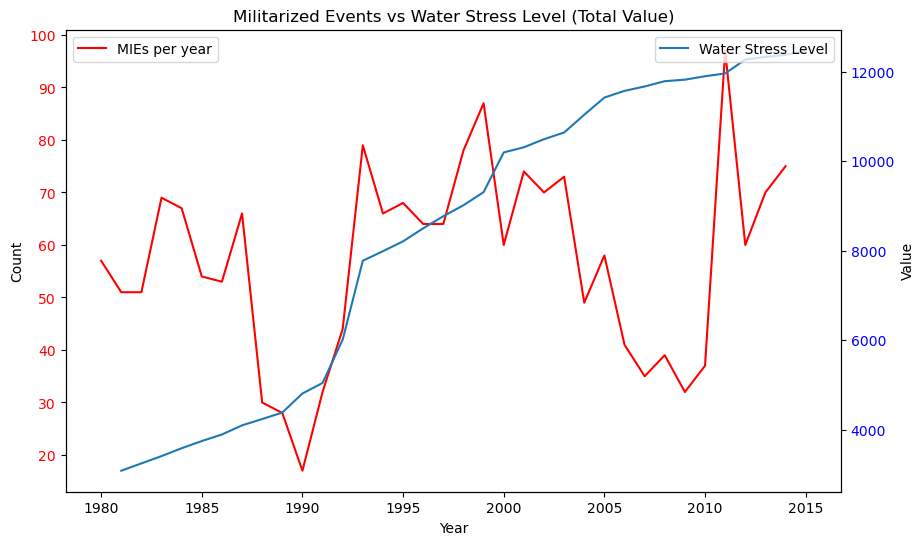

In [56]:
# Plot Militarized Events vs Water Stress Level (Total Value) - NOT USED
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=total_value_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level (Total Value)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_year(total_value).png', bbox_inches='tight') 
plt.show()

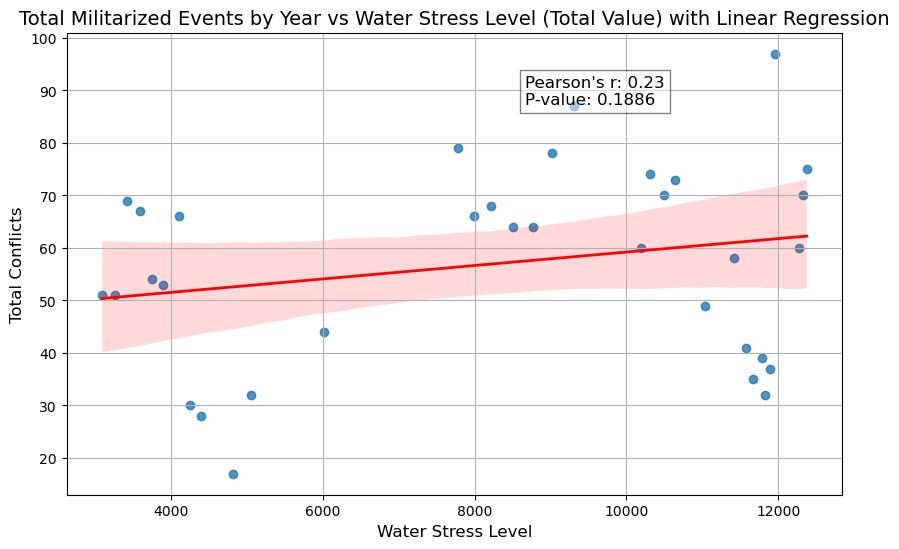

In [92]:
# Plot and calculate p and r values and linear regression

# Calculate correlation between Total Militarized Events by Year vs Water Stress Level (Total Value)
# Align the datasets on the same years
total_value_water_stress_merged_df = total_value_per_year_df.merge(total_conflicts_per_year_df, on='Year')
water_stress_values = total_value_water_stress_merged_df['Value']
total_value_conflicts_values = total_value_water_stress_merged_df['Total_Conflicts']

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, total_value_conflicts_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=water_stress_values, y=total_value_conflicts_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Total Militarized Events by Year vs Water Stress Level (Total Value) with Linear Regression', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('Total Conflicts', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(total_value_conflicts_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('water_stress_conflict_total_value_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

# Total Militarized Events by Year vs Water Stress Level (Total Value)
# Weak positive linear correlation (r = 0.23)
# No evidence against the null hypothesis (p = 0.1886)

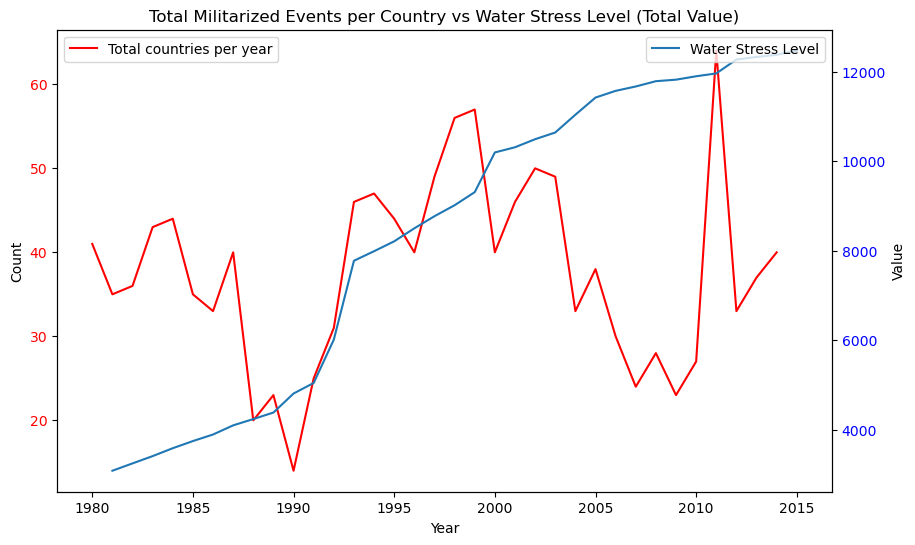

In [58]:
# Plot Militarized Events vs Water Stress Level (Total Value) - NOT USED
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=total_value_per_year_df, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events per Country vs Water Stress Level (Total Value)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('militarized_events_vs_water_stress_by_year(total_value).png', bbox_inches='tight') 
plt.show()

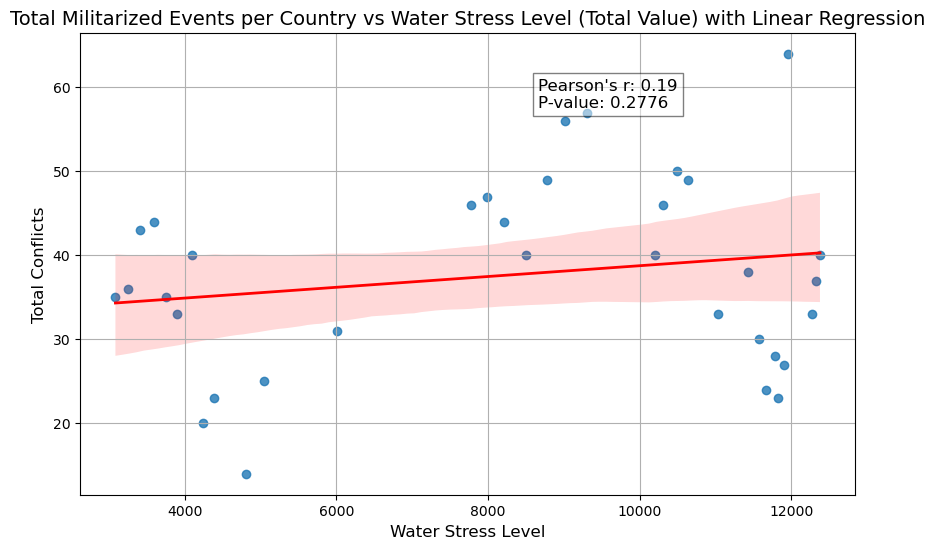

In [93]:
# Plot and calculate p and r values and linear regression

# Calculate correlation between Total Militarized Events per Country by Year vs Water Stress Level (Total Value)
# Align the datasets on the same years
total_value_country_water_stress_merged_df = total_value_per_year_df.merge(no_of_countries_by_year_df, on='Year')
water_stress_values = total_value_country_water_stress_merged_df['Value']
total_value_country_conflicts_values = total_value_country_water_stress_merged_df['Number_of_Countries_in_Conflict']

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, total_value_country_conflicts_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=water_stress_values, y=total_value_country_conflicts_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Total Militarized Events per Country vs Water Stress Level (Total Value) with Linear Regression', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('Total Conflicts', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(total_value_country_conflicts_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('water_stress_conflict_by_country_total_value_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

# Total Militarized Events per Country by Year vs Water Stress Level (Total Value)
# Weak positive linear correlation (r = 0.19)
# No evidence against the null hypothesis (p = 0.2776)

## Question 5 - Are there other factors that affect the frequency of armed conflicts in water scarce areas?

Check against two other variables (GDP and CO2 Emissions) using WDI data

In [61]:
# Display WDI Dataframe
WDI_df.head()

,Country Name,Country Code,Series Name,Series Code,1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],...,2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015]
0,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,75.6029242323162,75.6959573806835,76.8422110237843,76.5974772799729,76.6024728497366,76.0495676429734,...,51.8801297987834,51.8911235516106,52.966802416295,51.9946192893429,52.0244359748872,51.6598102561403,51.434801818807,51.2004449275282,50.8094847365935,47.1934417463395
1,World,WLD,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,..,7.0910700563557,7.16024597566327,7.00093699145194,6.87155631154786,6.6958143602211,...,3.17072353955477,3.34625038441823,3.51161492194638,3.62617466845568,3.83079042429474,3.97244074140658,4.00944164694051,4.14482511964403,4.12759739539601,4.21044204006536
2,World,WLD,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,8.99785000063423,9.00101020530396
3,World,WLD,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,..,..,..,..,..,..,...,..,..,..,..,69.7497316936597,..,..,..,..,..
4,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,..,..,..,..,..,..,...,4.41709984339302,4.52826428575511,4.50380815254763,4.3914854392157,4.60492937876465,4.68950582813015,4.68534777048442,4.71956435074903,4.68223911436346,4.6014345417289


In [62]:
# Manipulate the dataframe for easier use

# Set the columns that should stay as identifiers
WDI_indexed_df = WDI_df.set_index(['Country Name', 'Country Code', 'Series Name', 'Series Code'])

# Stack the DataFrame to convert the columns into rows
WDI_stacked_df = WDI_indexed_df.stack().reset_index(name='Value')

# Rename columns
WDI_stacked_df.rename(columns={'level_4': 'Year'}, inplace=True)

# Extract the year from the 'Year' column
WDI_stacked_df['Year'] = WDI_stacked_df['Year'].str.extract(r'(\d{4})').astype(int)

# Display the reshaped DataFrame
WDI_stacked_df.head()

,Country Name,Country Code,Series Name,Series Code,Year,Value
0,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1980,75.6029242323162
1,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1981,75.6959573806835
2,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1982,76.8422110237843
3,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1983,76.5974772799729
4,World,WLD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1984,76.6024728497366


In [63]:
# Filter to include only rows with the keyword "NY.GDP.MKTP.CD" in the Series Code column
keyword = 'NY.GDP.MKTP.CD'
WDI_GDP = WDI_stacked_df['Series Code'].str.contains(keyword, case=False, na=False)
WDI_GDP_df = WDI_stacked_df[WDI_GDP]

# Display dataframe
WDI_GDP_df.head()

,Country Name,Country Code,Series Name,Series Code,Year,Value
504,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1980,11419164161217.7
505,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1981,11796482847017.7
506,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1982,11648085880486.3
507,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1983,11972210792643.6
508,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1984,12445989345469.1


In [64]:
# Drop unneccesary columns for clarity

WDI_GDP_columns_to_drop = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
WDI_GDP_existing_columns_to_drop = [col for col in WDI_GDP_columns_to_drop if col in WDI_GDP_df.columns]

if WDI_GDP_existing_columns_to_drop:
   WDI_GDP_df = WDI_GDP_df.drop(columns=WDI_GDP_existing_columns_to_drop)
else:
    print("No columns to drop.")

In [65]:
# Check the value types
print(WDI_GDP_df.dtypes)

Year      int32
Value    object
dtype: object


In [66]:
# Change value to float
WDI_GDP_df['Value'] = WDI_GDP_df['Value'].astype(float)
print(WDI_GDP_df.dtypes)

Year       int32
Value    float64
dtype: object


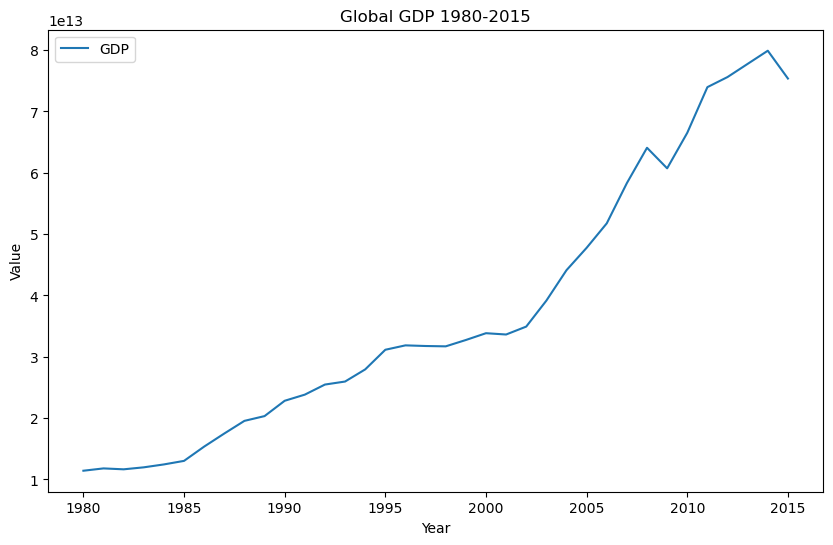

In [67]:
# Plot Global GDP by year  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=WDI_GDP_df, x='Year', y='Value', label='GDP')
plt.title('Global GDP 1980-2015')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

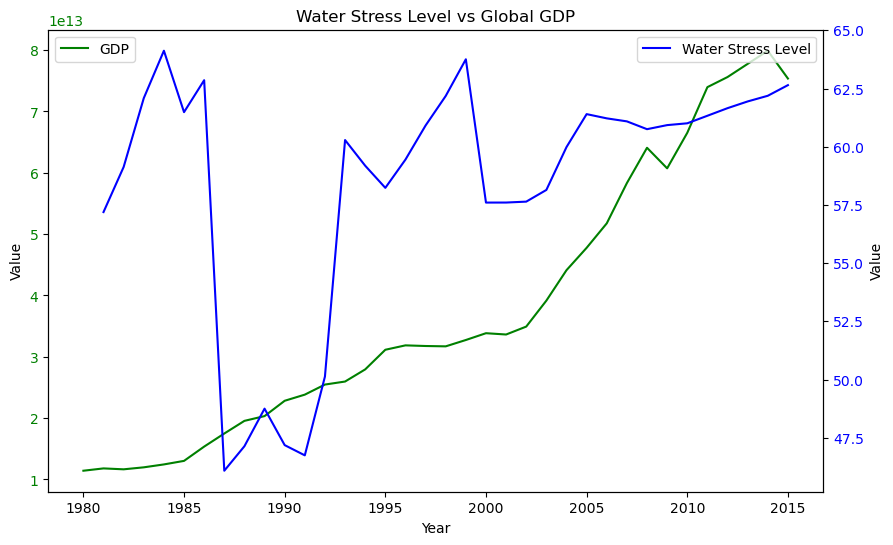

In [68]:
#Plot Water Stress Level vs Global GDP - USED IN SLIDE 6
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GDP
sns.lineplot(data=WDI_GDP_df, x='Year', y='Value', label='GDP', color='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.tick_params(axis='y', labelcolor='green')

# Create twin axes for Water Stress Level
ax2 = ax1.twinx()
sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level', color='blue', ax=ax2)
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
ax1.set_title('Water Stress Level vs Global GDP')

plt.savefig('water_stress_GDP.png', bbox_inches='tight') 
plt.show()

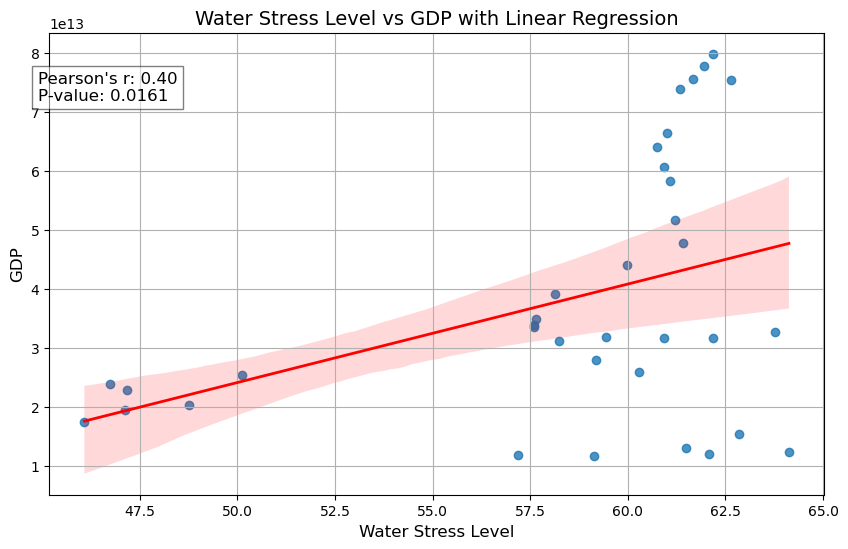

In [83]:
# Plot and calculate p and r values and linear regression

# Calculate correlation between GDP vs Water Stress Level (Overall Percentage)
# Align the datasets on the same years
GDP_water_stress_merged_df = overall_percentage_per_year_df.merge(WDI_GDP_df, on='Year')
water_stress_values = GDP_water_stress_merged_df['Value_x']
GDP_values = GDP_water_stress_merged_df['Value_y']

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(water_stress_values, GDP_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=water_stress_values, y=GDP_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Water Stress Level vs GDP with Linear Regression', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('GDP', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(water_stress_values)*0.7, y=max(GDP_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('water_stress_gdp_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

# GDP vs Water Stress Level (Overall Percentage)
# Moderate positive linear correlation (r = 0.4)
# Moderate evidence against the null hypothesis (p = 0.0161)

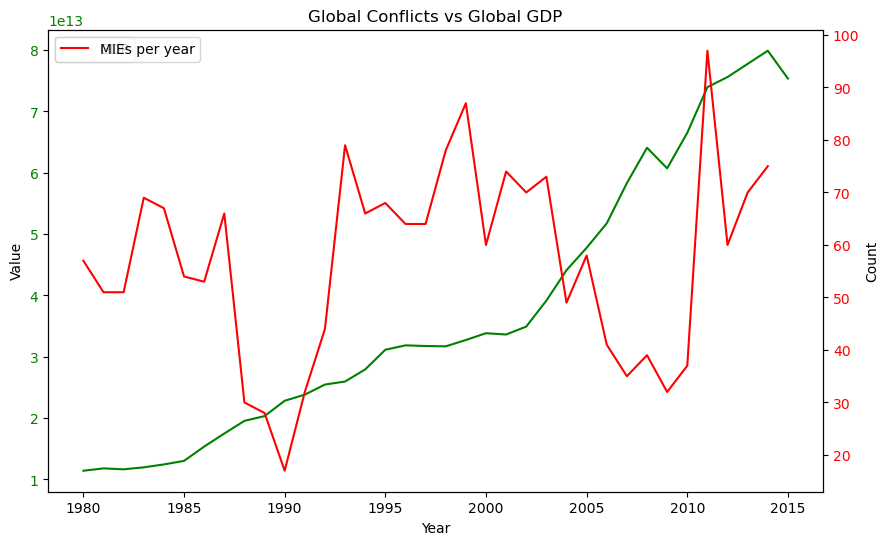

In [102]:
#PlotGlobal Conflict vs Global GDP - USED IN SLIDE 6
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GDP
sns.lineplot(data=WDI_GDP_df, x='Year', y='Value', label='GDP', color='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.tick_params(axis='y', labelcolor='green')

# Create twin axes for Water Stress Level
ax2 = ax1.twinx()
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red", ax=ax2)
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='red')

# Add title
ax1.set_title('Global Conflicts vs Global GDP')

plt.savefig('conflict_GDP.png', bbox_inches='tight') 
plt.show()

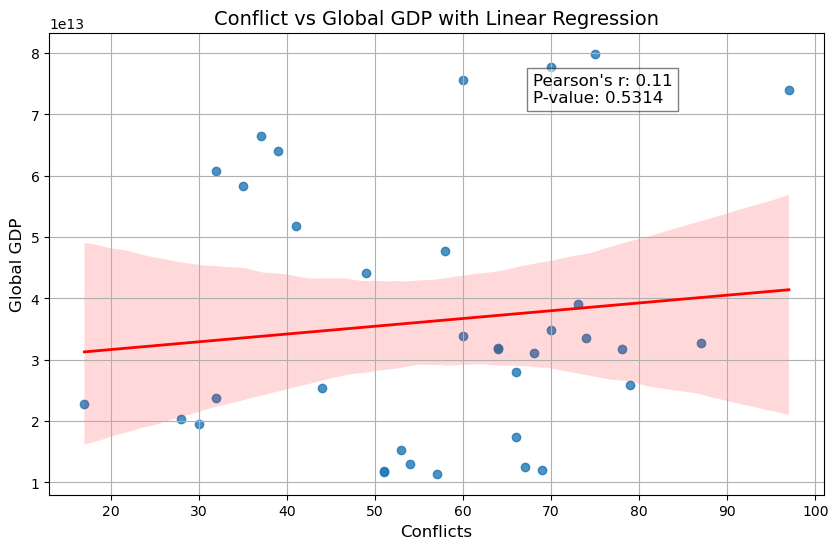

In [99]:
# Plot and calculate p and r values and linear regression

# Global GDP vs Conflicts
# Align the datasets on the same years
GDP_conflict_merged_df = total_conflicts_per_year_df.merge(WDI_GDP_df, on='Year')

# Extract the values for plotting
conflict_values = GDP_conflict_merged_df['Total_Conflicts']
GDP_values = GDP_conflict_merged_df['Value']

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(conflict_values, GDP_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=conflict_values, y=GDP_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Conflict vs Global GDP with Linear Regression', fontsize=14)
plt.xlabel('Conflicts', fontsize=12)
plt.ylabel('Global GDP', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(conflict_values)*0.7, y=max(GDP_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('conflict_gdp_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

In [69]:
# Filter to include only the rows including the keyword "EN.ATM.CO2E.PC" in Series Code columns
keyword = 'EN.ATM.CO2E.PC'
WDI_CO2 = WDI_stacked_df['Series Code'].str.contains(keyword, case=False, na=False)
WDI_CO2_df = WDI_stacked_df[WDI_CO2]

# Display dataframe
WDI_CO2_df

,Country Name,Country Code,Series Name,Series Code,Year,Value
144,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1980,..
145,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1981,..
146,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1982,..
147,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1983,..
148,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1984,..
149,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1985,..
150,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1986,..
151,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1987,..
152,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1988,..
153,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1989,..


In [70]:
# Drop unneccesary columns
WDI_CO2_columns_to_drop = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
WDI_CO2_existing_columns_to_drop = [col for col in WDI_CO2_columns_to_drop if col in WDI_CO2_df.columns]

if WDI_CO2_existing_columns_to_drop:
   WDI_CO2_df = WDI_CO2_df.drop(columns=WDI_CO2_existing_columns_to_drop)
else:
    print("No columns to drop.")

In [71]:
# Check datatypes
print(WDI_CO2_df.dtypes)

Year      int32
Value    object
dtype: object


In [72]:
# Change datatype for ease of use
WDI_CO2_df['Value'] = pd.to_numeric(WDI_CO2_df['Value'], errors='coerce')
print(WDI_CO2_df.dtypes)

Year       int32
Value    float64
dtype: object


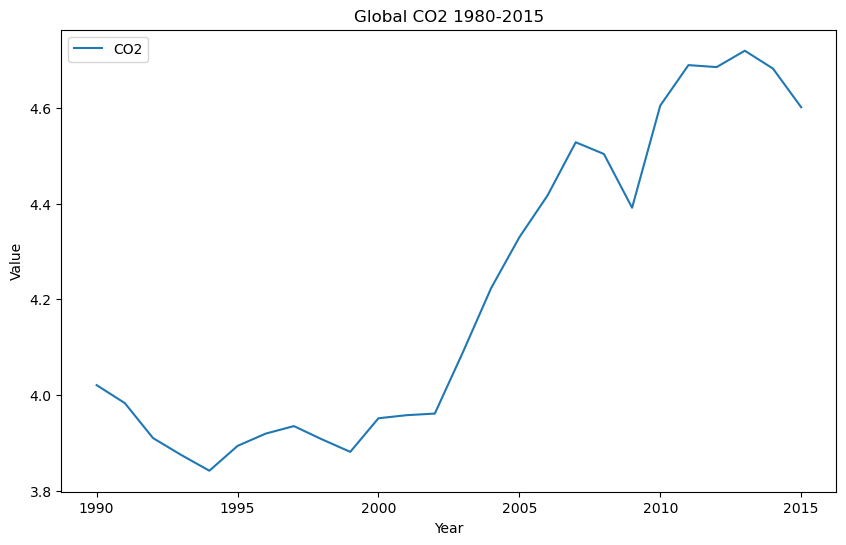

In [73]:
# Plot Global CO2 by year  - NOT USED IN PRESENTATION
plt.figure(figsize=(10, 6))
sns.lineplot(data=WDI_CO2_df, x='Year', y='Value', label='CO2')
plt.title('Global CO2 1980-2015')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

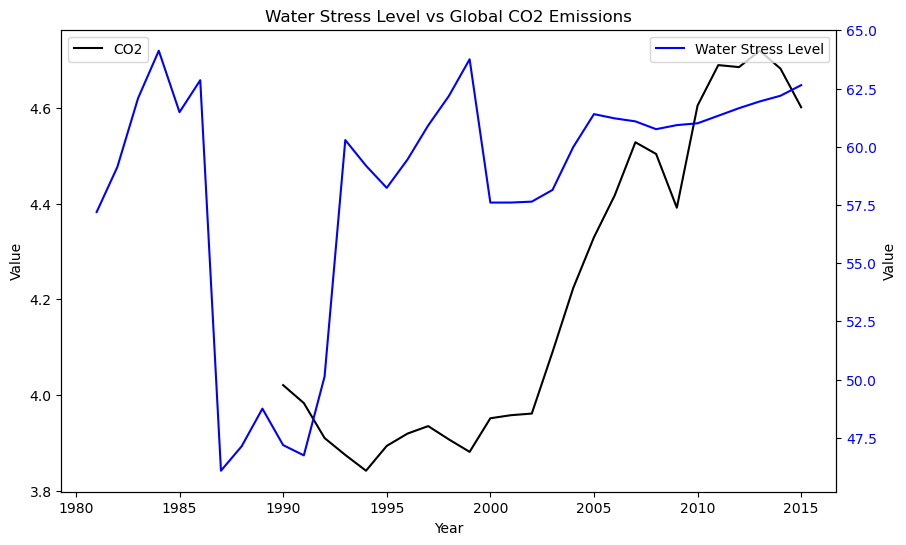

In [74]:
#Plot Combined Water Stress and CO2 Chart - USED IN SLIDE 6
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot CO2 Data
sns.lineplot(data=WDI_CO2_df, x='Year', y='Value', label='CO2', color='black')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.tick_params(axis='y', labelcolor='black')

# Create twin axes for Water Stress Level
ax2 = ax1.twinx()
sns.lineplot(data=overall_percentage_per_year_df, x='Year', y='Value', label='Water Stress Level', color='blue', ax=ax2)
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
ax1.set_title('Water Stress Level vs Global CO2 Emissions')

plt.savefig('water_stress_CO2.png', bbox_inches='tight') 
plt.show()

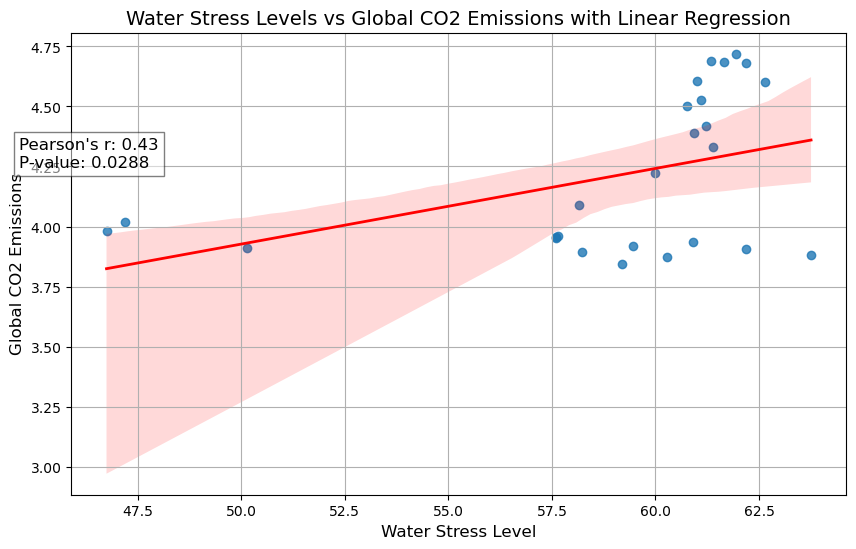

In [85]:
# Plot and calculate p and r values and linear regression

# Global CO2 Emissions vs Water Stress Level (Overall Percentage)
# Align the datasets on the same years
CO2_water_stress_merged_df = overall_percentage_per_year_df.merge(WDI_CO2_df, on='Year')

# Extract the values for plotting
water_stress_values = CO2_water_stress_merged_df['Value_x']
CO2_values = CO2_water_stress_merged_df['Value_y']

# Remove NaN and infinite values
valid_indices = np.isfinite(water_stress_values) & np.isfinite(CO2_values)
clean_water_stress_values = water_stress_values[valid_indices]
clean_CO2_values = CO2_values[valid_indices]

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(clean_water_stress_values, clean_CO2_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=clean_water_stress_values, y=clean_CO2_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Water Stress Levels vs Global CO2 Emissions with Linear Regression', fontsize=14)
plt.xlabel('Water Stress Level', fontsize=12)
plt.ylabel('Global CO2 Emissions', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(clean_water_stress_values)*0.7, y=max(clean_CO2_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('water_stress_co2gdp_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

# Water Stress Levels vs Global CO2 Emissions with Linear Regression
# Moderate positive linear correlation (r = 0.43)
# Weak evidence against the null hypothesis (p = 0.0288)

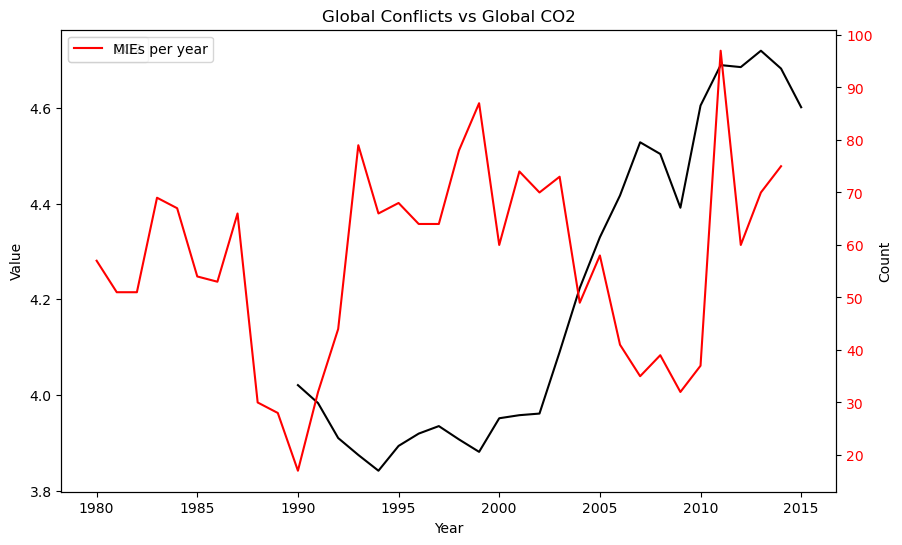

In [101]:
#PlotGlobal Conflict vs Global CO2 - USED IN SLIDE 6
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot CO2 Data
sns.lineplot(data=WDI_CO2_df, x='Year', y='Value', label='CO2', color='black')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.tick_params(axis='y', labelcolor='black')

# Create twin axes for Water Stress Level
ax2 = ax1.twinx()
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red", ax=ax2)
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='red')

# Add title
ax1.set_title('Global Conflicts vs Global CO2')

plt.savefig('conflict_CO2.png', bbox_inches='tight') 
plt.show()

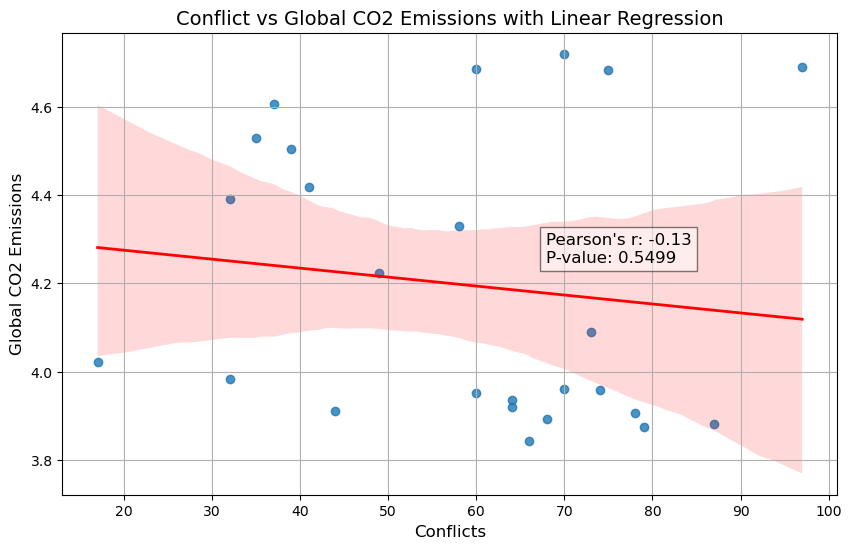

In [100]:
# Plot and calculate p and r values and linear regression

# Global CO2 Emissions vs Conflicts
# Align the datasets on the same years
CO2_conflict_merged_df = total_conflicts_per_year_df.merge(WDI_CO2_df, on='Year')

# Extract the values for plotting
conflict_values = CO2_conflict_merged_df['Total_Conflicts']
CO2_values = CO2_conflict_merged_df['Value']

# Remove NaN and infinite values
valid_indices = np.isfinite(conflict_values) & np.isfinite(CO2_values)
clean_conflict_values = conflict_values[valid_indices]
clean_CO2_values = CO2_values[valid_indices]

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(clean_conflict_values, clean_CO2_values)

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=clean_conflict_values, y=clean_CO2_values, ci=95, line_kws={'color':'red', 'linewidth':2})

# Customizing the scatter plot
plt.title('Conflict vs Global CO2 Emissions with Linear Regression', fontsize=14)
plt.xlabel('Conflicts', fontsize=12)
plt.ylabel('Global CO2 Emissions', fontsize=12)
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(clean_conflict_values)*0.7, y=max(clean_CO2_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Save the scatter plot and regression line
plt.savefig('conflict_co2_regression.png', bbox_inches='tight') 

# Display the plot
plt.show()

## Summary of Findings
#### Based on the above analysis, the strongest correlations are between Total Militarized Events by Year and the overall percentage of Water Stress Level, followed by Total Militarized Events per Country by Year and overall percentage of Water Stress Level.  There was also a moderate correlation, with moderate evidence, between GDP and Water Stess levels on a global scale.  See results below:  

### Total Militarized Events by Year vs Water Stress Level (Overall Percentage)
##### Moderate positive linear correlation (r = 0.51)
##### Strong evidence against the null hypothesis (p = 0.0023)

### Total Militarized Events per Country by Year vs Water Stress Level (Overall Percentage)
##### Moderate positive linear correlation (r = 0.47)
##### Strong evidence against the null hypothesis (p = 0.005)

### Total Militarized Events by Year vs Water Stress Level (Total Value)
##### Weak positive linear correlation (r = 0.23)
##### No evidence against the null hypothesis (p = 0.1886)

### Total Militarized Events per Country by Year vs Water Stress Level (Total Value)
##### Weak positive linear correlation (r = 0.19)
##### No evidence against the null hypothesis (p = 0.2776)

### GDP vs Water Stress Level (Overall Percentage)
##### Moderate positive linear correlation (r = 0.4)
##### Moderate evidence against the null hypothesis (p = 0.0161)

### GDP vs Conflict
#### Weak positive linear correlation (r = 0.11)
#### Weak evidence against the null hypothesis (p = 0.5314

### Global CO2 Emissions vs Water Stress Level (Overall Percentage)
##### Moderate positive linear correlation (r = 0.43)
##### Weak evidence against the null hypothesis (p = 0.028

### Global CO2 Emissions vs Conflict
#### Weak negative linear correlation (r = -0.13)
#### Weak evidence against the null hypothesis (p = 0.5499)

#### Note: Analysis was not conducted to determine whether or no water stress is the cause of conflict or conflict causes/exacerbates water stress.  More research needs to be done in order to form a better conclusion. 